In [9]:
'''
This script is demo for one-one corresponding dataset with
CCA-zoo implemented MCCA, to estimate the PI
'''
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# '''
# This part is essential to test the Python and MATLAB callability.
# To apply the fmincon function in MATLAB to solve the minimization problem.
# '''
# import matlab
# import matlab.engine

# ########################
# mat_eng = matlab.engine.start_matlab()

In [5]:
# # generate the Synthetic data from matlab
# n = 50
# d = 3
# dx = 12
# dy = 12

# X, Y_init, Sx, Sy, S  = mat_eng.gen_cca_data(n, d, dx, dy, nargout=5)

# print("# the X is : ", np.array(X).shape)
# print("# the Y is : ", np.array(Y_init).shape)
# print("# the Sx is : ")
# print(np.array(Sx).shape)
# print("# the Sy is : ")
# print(np.array(Sy).shape)
# print("# S is : ")
# print(np.array(S).shape)

In [6]:
# #################################
# #      Generate the dataset     #
# #################################
# import random

# # randomize the order of data samples in Y
# Y_order = np.array(random.sample(range(n), n))
# # re-ordered dataset Y
# Y = np.zeros((np.array(Y_init).shape[0], np.array(Y_init).shape[1]))

# true_PI = np.zeros((n, n))
# for i in range(len(Y_order)):
#     Y_i = int(Y_order[i])
#     Y[i] = np.array(Y_init)[Y_i]
#     # generate the groundtruth PI
#     true_PI[i][Y_i] = 1

# # reshape the X, Y datasets and permutation matrix
# X = np.array(X).T
# Y = Y.T
# true_PI = true_PI

# print(X.shape)
# print(Y.shape)
# print(true_PI.shape)

In [11]:
#################################
#    Function for MAXVAR MCCA   #
#################################

from cca_zoo.utils.check_values import _process_parameter
from heapq import nlargest

def MAXVAR_MCCA(X, Y, PI):
    '''
    update the projections by Max-of-Variance MCCA
    input: X --> the first dataset
           Y --> the second dataset
           PI --> the estimated permutation matrix
    Output: U --> the projection matrix for dataset X
            V --> the projection matrix for dataset Y
            S --> the common resource matrix
    '''
    # common termed to be used
    c = 0.01
    YPI = np.dot(Y, PI)
    XXT_inv = np.linalg.inv(np.dot(X, X.T) + c*np.identity(X.shape[0]))
    YPI_YPIT_inv = np.linalg.inv(np.dot(YPI, YPI.T) + c*np.identity(YPI.shape[0]))
    
    # estimate the common resource matrix S
    f_1 = np.dot(X.T, np.dot(XXT_inv, X))
    f_2 = np.dot(YPI.T, np.dot(YPI_YPIT_inv, YPI))
    f = 0.02 * f_1 + f_2
    # Compute the Eigenvectors and eigenvalues for function f, as complex numbers
    eigenvalues, eigenvectors = np.linalg.eig(f)
    # only takes the real part of the complex numbers
    eigenvalues = eigenvalues.real.tolist()
    eigenvectors = eigenvectors.real
    # the first d columns of eigenvectors should be the values of S
    largest_eigen = nlargest(latent_dims, eigenvalues)
    S = []
    for principal_eigenvalue in largest_eigen:
        eigen_idx = eigenvalues.index(principal_eigenvalue)
        eigen_vec = eigenvectors[eigen_idx]
        S.append(eigen_vec)
    # convert the S matrix into array
    S = np.array(S)
    
    # estimate the projections U and V
    U = np.dot(XXT_inv, np.dot(X, S.T))
    V = np.dot(YPI_YPIT_inv, np.dot(YPI, S.T))
    
    return U, V, S

In [8]:
#####################################################
#          Test the procrustes.permutation          #
#                                                   #
#             Test with Original Order              #
#####################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
from procrustes import permutation

print("### Experiment of data NO index feature!! ###")
### evaluate the permutation with Wiki_embeddings, NO 
X = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
Y = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw200.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 201)).T

### compute the SVD process
Ux, Sx, VHx = np.linalg.svd(X) #, full_matrices=False)
Uy, Sy, VHy = np.linalg.svd(Y) #, full_matrices=False)

print(Ux.shape)
print(Sx.shape)
print(VHx.shape)

### get the toop-K eigen values
k = 8
# process the X's SVD
Ux_k = np.zeros((Ux.shape[0], Ux.shape[1]))
Ux_k[:k, :k] = Ux[:k, :k]

Sx_k = np.zeros((Ux.shape[0], VHx.shape[0]))
for i in range(k):
    Sx_k[i][i] = Sx[i]

X_k = np.dot(np.dot(Ux_k, Sx_k), VHx)
X_k = X_k[:k, :]

# process the X's SVD
Uy_k = np.zeros((Uy.shape[0], Uy.shape[1]))
Uy_k[:k, :k] = Uy[:k, :k]

Sy_k = np.zeros((Uy.shape[0], VHy.shape[0]))
for i in range(k):
    Sy_k[i][i] = Sy[i]

Y_k = np.dot(np.dot(Uy_k, Sy_k), VHy)
Y_k = Y_k[:k, :]


esti_PI_NoIdx = permutation(X_k, Y_k, pad=True)

### Experiment of data NO index feature!! ###


OSError: Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt not found.

In [ ]:
##########################################
### Permutation evaluation -- NO index ###
##########################################

acc = 0.0
for i in range(2405):
    esti_idx_NoIdx = np.where(esti_PI_NoIdx.t[i]==1)[0][0]
    if esti_idx_NoIdx == i:
        acc += 1
print("# Accuracy of permutation(No index) is: ", acc/2405)

# Accuracy of permutation(No index) is:  0.002079002079002079


In [ ]:
#####################################################
#          Test the procrustes.permutation          #
#    Test with wiki_dw128 and wiki_dw200 datasets   #
#                                                   #
#         Re-Order the second wiki_dw200 dataset    #
#####################################################

from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
from procrustes import permutation

import numpy as np
import random

print("### Experiment of data NO index feature!! ###")
### evaluate the permutation with Wiki_embeddings, NO 
X = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 129)).T
Y = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_node200.txt', delimiter = ' ', skiprows = 1, usecols=range(1, 201)).T

### reorder the second dataset
reorder = np.array(random.sample(range(2405), 2405))
Y = Y[:, reorder]

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][reorder[i]] = 1
    
print("### Test the true Permutation ...")
true_PI_order = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    true_PI_order.append(true_idx)
true_PI_order = np.array(true_PI_order)
print("# reorder:")
print(reorder)
print("# true PI order:")
print(true_PI_order)

    
### compute the SVD process
Ux, Sx, VHx = np.linalg.svd(X) #, full_matrices=False)
Uy, Sy, VHy = np.linalg.svd(Y) #, full_matrices=False)

print(Ux.shape)
print(Sx.shape)
print(VHx.shape)

### get the toop-K eigen values
k = 5
# process the X's SVD
Ux_k = np.zeros((Ux.shape[0], Ux.shape[1]))
Ux_k[:k, :k] = Ux[:k, :k]

Sx_k = np.zeros((Ux.shape[0], VHx.shape[0]))
for i in range(k):
    Sx_k[i][i] = Sx[i]

X_k = np.dot(np.dot(Ux_k, Sx_k), VHx)
X_k = X_k[:k, :]

# process the X's SVD
Uy_k = np.zeros((Uy.shape[0], Uy.shape[1]))
Uy_k[:k, :k] = Uy[:k, :k]

Sy_k = np.zeros((Uy.shape[0], VHy.shape[0]))
for i in range(k):
    Sy_k[i][i] = Sy[i]

Y_k = np.dot(np.dot(Uy_k, Sy_k), VHy)
Y_k = Y_k[:k, :]


esti_PI_NoIdx = permutation(Y_k, X_k, pad=True)    

### Experiment of data NO index feature!! ###
### Test the true Permutation ...
# reorder:
[1895  303 1853 ... 1262 1274  342]
# true PI order:
[1895  303 1853 ... 1262 1274  342]
(128, 128)
(128,)
(2405, 2405)


In [ ]:
##########################################
### Permutation evaluation -- NO index ###
##########################################
esti_order = []
true_PI_order = []
acc = 0.0
for i in range(2405):
    esti_idx_NoIdx = np.where(esti_PI_NoIdx.t[i]==1)[0][0]
    true_idx = np.where(true_PI[i]==1)[0][0]
    esti_order.append(esti_idx_NoIdx)
    true_PI_order.append(true_idx)
    if esti_idx_NoIdx == true_idx:
        acc += 1
print("# Accuracy of permutation(No index) is: ", acc/2405)
print("# the true order is : ", np.array(true_PI_order))
print("# the estimated order is : ", np.array(esti_order))

# Accuracy of permutation(No index) is:  0.0004158004158004158
# the true order is :  [1895  303 1853 ... 1262 1274  342]
# the estimated order is :  [2199  520 2373 ... 1755 2128 1390]


In [12]:
###########################################
#        Main Part of ACCA algorithm      #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y = np.loadtxt('Wiki_embeddings/wiki_dw200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T

### Calculate the number of elements to reorder (10% of the Y dataset)
num_elements_reorder = int(0.1 * Y.shape[1])
### Generate a permutation for the first 10% of the indices
reorder = np.array(random.sample(range(num_elements_reorder), num_elements_reorder))
### create array for the remaining 90% of indices
remaining_indices = np.array(range(num_elements_reorder, Y.shape[1]))
### concatenate the reordered indices with the remaining indices
new_order = np.concatenate((reorder, remaining_indices))
### Apply the new order (reorder 10% of the Y dataset)
Y = Y[:, new_order]

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][new_order[i]]= 1

print("Size of Y: \n", Y.shape)
from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 10
latent_dims = 8

esti_PI_history = []
acc_history = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
#         esti_PI = np.zeros((n, n))
#         for j in range(int(n)):
#             esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
            
        ### compute the SVD process
        Ux, Sx, VHx = np.linalg.svd(X) #, full_matrices=False)
        Uy, Sy, VHy = np.linalg.svd(Y) #, full_matrices=False)

        ### get the toop-K eigen values
        k = latent_dims
        # # process the X's SVD
        # Ux_k = np.zeros((Ux.shape[0], Ux.shape[1]))
        # Ux_k[:k, :k] = Ux[:k, :k]

        # Sx_k = np.zeros((Ux.shape[0], VHx.shape[0]))
        # for ii in range(k):
        #     Sx_k[i][i] = Sx[i]

        # X_k = np.dot(np.dot(Ux_k, Sx_k), VHx)
        # X_k = X_k[:k, :]

        # # process the X's SVD
        # Uy_k = np.zeros((Uy.shape[0], Uy.shape[1]))
        # Uy_k[:k, :k] = Uy[:k, :k]

        # Sy_k = np.zeros((Uy.shape[0], VHy.shape[0]))
        # for ii in range(k):
        #     Sy_k[i][i] = Sy[i]

        # Y_k = np.dot(np.dot(Uy_k, Sy_k), VHy)
        # Y_k = Y_k[:k, :]
        
        X_k = VHx[:k,:]
        Y_k = VHy[:k,:]
        esti_PI = permutation(Y_k, X_k).t
        
    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    esti_PI_order = []
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
        esti_PI_order.append(esti_idx)
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    print("# esti_PI order is : ", np.array(esti_PI_order))
    acc_history.append(acc)


Size of Y: 
 (200, 2405)
# evaluate- 0  :  1496  -  62  ...
# evaluate- 1  :  517  -  57  ...
# evaluate- 2  :  806  -  0  ...
# evaluate- 3  :  1565  -  157  ...
# evaluate- 4  :  546  -  12  ...
# evaluate- 5  :  54  -  55  ...
# evaluate- 6  :  1012  -  107  ...
# evaluate- 7  :  793  -  27  ...
# evaluate- 8  :  1160  -  91  ...
# evaluate- 9  :  179  -  156  ...
# evaluate- 10  :  885  -  79  ...
# evaluate- 11  :  783  -  2  ...
# evaluate- 12  :  979  -  195  ...
# evaluate- 13  :  1602  -  52  ...
# evaluate- 14  :  188  -  1  ...
# evaluate- 15  :  997  -  184  ...
# evaluate- 16  :  1106  -  88  ...
# evaluate- 17  :  864  -  90  ...
# evaluate- 18  :  1425  -  123  ...
# evaluate- 19  :  152  -  148  ...
# evaluate- 20  :  64  -  174  ...
# evaluate- 21  :  652  -  77  ...
# evaluate- 22  :  79  -  46  ...
# evaluate- 23  :  213  -  217  ...
# evaluate- 24  :  766  -  163  ...
# evaluate- 25  :  1574  -  85  ...
# evaluate- 26  :  1557  -  178  ...
# evaluate- 27  :  752  - 

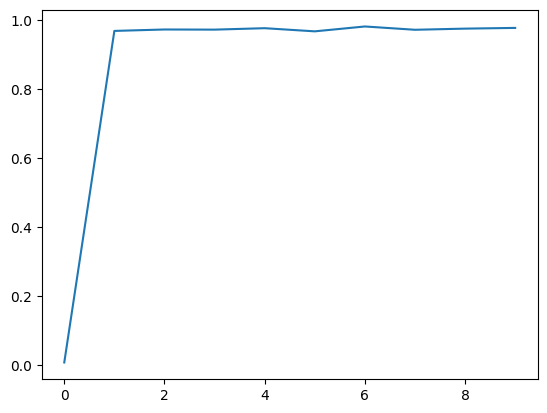

In [ ]:
plt.plot(np.array(acc_history) / 2405)

In [ ]:
###########################################
#        Main Part of ACCA algorithm      #
###########################################
import random

### load in the dataset
X = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw128.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 129)).T
Y_origin = np.loadtxt('Wiki_embeddings/Wiki_embeddings/wiki_dw200.txt', delimiter = ' ', \
               skiprows = 1, usecols=range(1, 201)).T

### reorder the Y dataset randomly
reorder = np.array(random.sample(range(2405), 2405))
Y = Y_origin[:, reorder]

### generate the true permutatoin
true_PI = np.zeros((2405, 2405))
for i in range(2405):
    true_PI[i][reorder[i]]= 1

print("# Re-arranged Order is : ")
print(reorder)
print("##########################")
print("# evaluate the true PI: ")
eval_true_PI = []
for i in range(2405):
    true_idx = np.where(true_PI[i]==1)[0][0]
    eval_true_PI.append(true_idx)
eval_true_PI = np.array(eval_true_PI)
print(eval_true_PI)
print("##########################")


from heapq import nlargest
import time
import copy
from procrustes import permutation

# the total training iterations
n = 2405
train_epoch = 10
latent_dims = 8

esti_PI_history = []
acc_history = []
for i in range(train_epoch):
    ## estimate the permutation matrix
    t_PI = time.time()
    if i > 0:
        XU = np.dot(X.T, U)
        YV = np.dot(Y.T, V)
        
        esti_PI = permutation(YV.T, S.T)
        esti_PI = np.array(esti_PI.t)
    else:
        # initialize the PI at totally random
#         esti_PI = np.zeros((n, n))
#         for j in range(int(n)):
#             esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]

        ### compute the SVD process
        Ux, Sx, VHx = np.linalg.svd(X) #, full_matrices=False)
        Uy, Sy, VHy = np.linalg.svd(Y) #, full_matrices=False)

        ### get the toop-K eigen values
        k = latent_dims
        # process the X's SVD
        Ux_k = np.zeros((Ux.shape[0], Ux.shape[1]))
        Ux_k[:k, :k] = Ux[:k, :k]

        Sx_k = np.zeros((Ux.shape[0], VHx.shape[0]))
        for ii in range(k):
            Sx_k[i][i] = Sx[i]

        X_k = np.dot(np.dot(Ux_k, Sx_k), VHx)
        X_k = X_k[:k, :]

        # process the X's SVD
        Uy_k = np.zeros((Uy.shape[0], Uy.shape[1]))
        Uy_k[:k, :k] = Uy[:k, :k]

        Sy_k = np.zeros((Uy.shape[0], VHy.shape[0]))
        for ii in range(k):
            Sy_k[i][i] = Sy[i]

        Y_k = np.dot(np.dot(Uy_k, Sy_k), VHy)
        Y_k = Y_k[:k, :]
        
        esti_PI = permutation(Y_k, X_k).t

    t_PI = time.time() - t_PI
    esti_PI_history.append(esti_PI)
    
    ## estimation of the CCA part
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    
    ### evaluate the permutation matrix
    PI = esti_PI_history[i]
    acc = 0.0
    for ii in range(2405):
        esti_idx = np.where(PI[ii]==1)[0]
        if esti_idx.size > 0:
            esti_idx = esti_idx[0]
        true_idx = np.where(true_PI[ii]==1)[0][0]
        # print("# evaluate-", ii, " : ", esti_idx, " - ", true_idx, " ...")
        if esti_idx == true_idx:
            acc += 1
    print("# Accuracy of iter = ", i, " is: ", acc/2405)
    acc_history.append(acc)


# Re-arranged Order is : 
[1309  605 2046 ... 2272 1702  289]
##########################
# evaluate the true PI: 
[1309  605 2046 ... 2272 1702  289]
##########################
# Accuracy of iter =  0  is:  0.006652806652806653
# Accuracy of iter =  1  is:  0.0004158004158004158
# Accuracy of iter =  2  is:  0.0004158004158004158
# Accuracy of iter =  3  is:  0.0004158004158004158
# Accuracy of iter =  4  is:  0.0004158004158004158
# Accuracy of iter =  5  is:  0.0004158004158004158
# Accuracy of iter =  6  is:  0.0004158004158004158
# Accuracy of iter =  7  is:  0.0004158004158004158
# Accuracy of iter =  8  is:  0.0004158004158004158
# Accuracy of iter =  9  is:  0.0004158004158004158
